In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

In [22]:
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2. 0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# WARNING: works ONLY for x̂ normal direction!
abc(x̂) = (ly) *
[ 0. 0  0  0
  0  1  0  0
  0  0  0  0
  0  0  0  1]


abc (generic function with 1 method)

In [23]:
# Circuit
Rs =   1e+4 # Ω
RL = 2*13.2 # Ω

# Parameters
Δt = 0.05e-9
ε0 = 8.854e-12
μ0 = 4e-7π
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr
η  = sqrt(μ / ε)

n̂  = x̂ = [1.0, 0.0]
nothing

In [24]:
a, b = 2.00, 0.08
n, m = 200, 4
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [25]:
DOF_NONE = 0
DOF_PEC  = 1
DOF_SRC  = 2
DOF_ABC  = 3
DOF_LOAD = 4
DOF_SG   = 5

function dof_type(n, m)
    global NUM_EDGES
    N = NUM_EDGES
    h = [  1+(2n+1)i: n+0+(2n+1)i for i=0:m]
    v = [n+1+(2n+1)i:2n+1+(2n+1)i for i=0:m-1]
    start, stop = extrema(h[3])
    h[3] = start:stop - 5
    
    dof_flag = zeros(Int64, N)
    
    dof_flag[(h[1])] .= DOF_PEC # BOTTOM
    dof_flag[(h[3])] .= DOF_PEC # MIDDLE
    dof_flag[(h[5])] .= DOF_PEC # TOP
    
    dof_flag[first(v[1])] = DOF_SRC
    dof_flag[first(v[2])] = DOF_SRC
    
    dof_flag[first(v[3])] = DOF_SG
    dof_flag[first(v[4])] = DOF_SG
    
    dof_flag[ last(v[1])] = DOF_LOAD
    dof_flag[ last(v[2])] = DOF_LOAD
    dof_flag[ last(v[3])] = DOF_LOAD
    dof_flag[ last(v[4])] = DOF_LOAD
    
    return dof_flag
end

dof_type (generic function with 1 method)

In [26]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(n, m)
f = Γ .!= DOF_PEC
NUM_DOFS = NUM_EDGES;

In [27]:
using SparseArrays
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = spzeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
R = spzeros(NUM_DOFS, NUM_DOFS) # μ0 σ ∫( ∇Ni ⋅ ∇Nj )dΩ
T = spzeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
B = spzeros(NUM_DOFS, NUM_DOFS) # μ0/η ∫(( n̂ × ∇Ni ) ⋅ ( n̂ × ∇Nj ))dΓ

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  Be = abc(n̂) # works only for x̂ normal direction
  
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
            
    
      if Γ[jj] == DOF_ABC
        B[jj, kk] = B[jj, kk] + (μ0/η) * dj * dk * Be[jedge, kedge]
      end
    end
  end
end

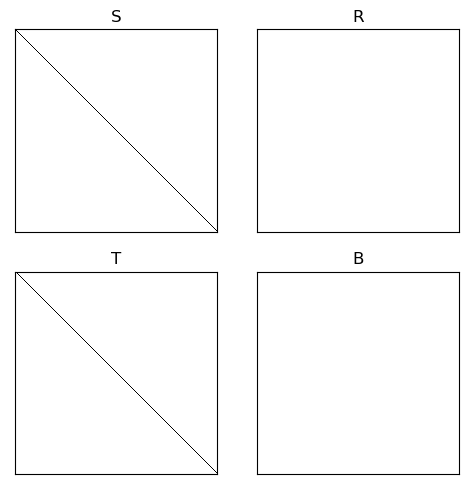

In [28]:
using PyPlot
figure(figsize=(5, 5))
subplot(2, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(2, 2, 2); spy(R); title("R"); xticks([]); yticks([]);
subplot(2, 2, 3); spy(T); title("T"); xticks([]); yticks([]);
subplot(2, 2, 4); spy(B); title("B"); xticks([]); yticks([]);
tight_layout()

In [29]:
A  = (+0.25Δt^2 * S +  T + 0.5Δt * B + 0.5Δt * R)
for ii = 1:NUM_EDGES
  if Γ[ii] == DOF_PEC
        A[:,dof[ii]].= 0.0
        A[dof[ii],:].= 0.0
        A[dof[ii], dof[ii]] = 1.0
  end
end

In [90]:
struct Dual{T <:Number} <:Number
     v::T
    dv::T
end

import Base: +, -, *, /
-(x::Dual)          = Dual(-x.v,       -x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v,  x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v,  x.dv - y.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v,  x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

import Base: abs, sin, cos, tan, exp, log, sqrt, conj, abs2, isless
abs(x::Dual)  = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual)  = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual)  = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual)  = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual)  = Dual(exp(x.v), exp(x.v)*x.dv)
log(x::Dual)  = Dual(log(x.v), x.dv/x.v)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
conj(x::Dual) = x
abs2(x::Dual) = abs(x) * abs(x)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: convert, promote_rule
convert(::Type{Dual{T}}, x::Dual) where T = Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T = Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} = Dual{promote_type(T,R)}

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ε]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

ε = Dual(0., 1.)

(0.0) + [1.0ε]

In [146]:
using ACME

cir = @circuit begin
    v  = voltagesource(), [-] == gnd
    i  = currentprobe(),  [-] == gnd
    r1 = resistor(1e-9),  [1] == v[+]
    d1 = diode(is=1e-6),  [-] == r1[2], [+] == i[+]
end

include("circuit-model.jl");
dmodel = let
    A = @SMatrix [0.0]
    B = @SMatrix [0.0]
    C = @SMatrix [0.0]
    Di = @SMatrix [0.0]
    _, _, _, _, Ei, Fi, Dv, Ev, Fv, Dq, Eq, Fq = matrices(cir, Δt, 1)
    x̄, y, ū, q̄, z = states(B, C, Di, Dq, T=Dual{Float64})
    DifferentiableModel(A, B, C, Di, Ei, Fi, Dq, Eq, Fq,
        x̄, y, ū, q̄, z, Dict{String,Any}())
end

function foo(q, ::Dict{String,Any})
    Is1, Is2 = 1e-4,  1e-4
    Vt1, Vt2 = 25e-3, 25e-3
    j = @SMatrix[(Is1 * exp(q[1]/Vt1) - Is1 - q[2])]
    J = @SMatrix[(Is1 / Vt1 * exp(q[1]/Vt1)) -1.0]
    return j, J
end

function bar(q, ::Dict{String,Any})
end

bar (generic function with 1 method)

In [147]:
dmodel.A

1×1 SMatrix{1, 1, Float64, 1} with indices SOneTo(1)×SOneTo(1):
 0.0

In [148]:
sigmoid(x) = 1.0 / (1.0 + exp(-5x))
Rsp(t, tswitch) = 1e15 - 1e15sigmoid(t - tswitch) + 6e-1

function assemble_circuit!(i, didv, v, t)
    for ii = 1:NUM_EDGES
        jj = dof[ii]
        if Γ[ii] == DOF_SG
            y = step!(copy(dmodel), v[jj] + ε, foo, bar)
            i[jj], didv[jj, jj] = value(first(y)), partials(first(y))
            #i[jj] = v[jj] * 1.0 / Rsp(1e9t, 15_000) * (b / ly)
            #didv[jj, jj] =  1.0 / Rsp(1e9t, 15_000) * (b / ly)
        end

        if Γ[ii] == DOF_SRC
            i[jj] = v[jj] * 1.0 / Rs * (b / ly)
            didv[jj, jj] =  1.0 / Rs * (b / ly)
        end

        if Γ[ii] == DOF_LOAD
            i[jj] = v[jj] * 1.0 / RL * (b / ly)
            didv[jj, jj] =  1.0 / RL * (b / ly)
        end
    end
end
#ts = 1e9Δt * collect(1:nt)
#xlabel("time (ns)")
#plot(ts, Rsp.(ts, 15), "r.-")
#ylabel("Resistance (Ω)")

assemble_circuit! (generic function with 1 method)

In [159]:
using JLD2

x = 0.010:0.050:0.51
y = 0.005:0.012:0.07
xx, yy = meshgrid(x, y);

it  = 1
nt  = 3*5000
t   = 0.00 + 15000e-9
e   = zeros(NUM_EDGES)
i   = zeros(NUM_EDGES)

e0  = zeros(NUM_EDGES)
ep  = zeros(NUM_EDGES)
epp = zeros(NUM_EDGES)
ip  = zeros(NUM_EDGES)
ipp = zeros(NUM_EDGES)

e0 .= -0.01load("blumlein-e0-$n-$m-$a-$b.jld2", "e0")
ep .= e0
epp.= e0

didv = spzeros(NUM_EDGES, NUM_EDGES)
res = zeros(nt, 11, 6, 2)
vRsg = zeros(nt)
vRL  = zeros(nt)
iRsg = zeros(nt)
iRL  = zeros(nt)
nothing

In [160]:
N = 0
Δe = similar(e)
@elapsed for _ = it:nt
    bi = (0.50Δt^2 * S - 2T) * ep + (0.25Δt^2 * S +  T - 0.5Δt * B - 0.5Δt * R) * epp
    
    fill!(Δe, Inf)
    while norm(Δe) > 1e-12 && N < 10
        assemble_circuit!(i, didv, e, t)
        Fi = A*e + 0.5Δt * ly^2 * μ0 * i - 0.5Δt * ly^2 * μ0 * ipp + bi
        Ji = A   + 0.5Δt * ly^2 * μ0 * didv
        Δe .= Ji\Fi
        e .-= Δe
        N += 1
    end
    println("[linear] $it [nonlinear] converged in $N iterations with $(norm(Δe))")
    step!(dmodel, sum(e[dof[Γ .== DOF_SG]]), foo, bar)
    fix!(dmodel)
    N = 0
    
    epp .= ep
    ep  .= e

    ipp .= ip
    ip  .= i
    
    res[it, :, :, :] .= evaluate(WhitneyRectangleElement(), e, dof, x, y, n, m, lx, ly, el2ed, el2edd)
    vRsg[it] = sum(e[dof[Γ .== DOF_SG]])
    vRL[it]  = sum(e[dof[Γ .== DOF_LOAD]])
    iRsg[it] = sum(i[dof[Γ .== DOF_SG]])
    iRL[it]  = sum(i[dof[Γ .== DOF_LOAD]])



    it += 1
    t  += Δt
end

[linear] 1 [nonlinear] converged in 2 iterations with 5.719638818030104e-17
[linear] 2 [nonlinear] converged in 2 iterations with 4.008837210624534e-17
[linear] 3 [nonlinear] converged in 2 iterations with 4.3630432565686403e-17
[linear] 4 [nonlinear] converged in 2 iterations with 4.164921793999363e-17
[linear] 5 [nonlinear] converged in 2 iterations with 4.0716006714196267e-17
[linear] 6 [nonlinear] converged in 2 iterations with 4.278715642223189e-17
[linear] 7 [nonlinear] converged in 2 iterations with 4.1029993000595994e-17
[linear] 8 [nonlinear] converged in 2 iterations with 4.090115058396645e-17
[linear] 9 [nonlinear] converged in 2 iterations with 4.1606816188421055e-17
[linear] 10 [nonlinear] converged in 2 iterations with 4.171288677519122e-17
[linear] 11 [nonlinear] converged in 2 iterations with 3.9178262359728145e-17
[linear] 12 [nonlinear] converged in 2 iterations with 4.129356720221185e-17
[linear] 13 [nonlinear] converged in 2 iterations with 4.157703056501448e-17
[li

[linear] 117 [nonlinear] converged in 2 iterations with 4.1122539262924734e-17
[linear] 118 [nonlinear] converged in 2 iterations with 4.0176669062579856e-17
[linear] 119 [nonlinear] converged in 2 iterations with 4.046445130653315e-17
[linear] 120 [nonlinear] converged in 2 iterations with 3.903625746520023e-17
[linear] 121 [nonlinear] converged in 2 iterations with 3.930144913295358e-17
[linear] 122 [nonlinear] converged in 2 iterations with 3.983988446834896e-17
[linear] 123 [nonlinear] converged in 2 iterations with 4.18257067198166e-17
[linear] 124 [nonlinear] converged in 2 iterations with 3.978250612783109e-17
[linear] 125 [nonlinear] converged in 2 iterations with 4.1950063881179406e-17
[linear] 126 [nonlinear] converged in 2 iterations with 4.194071941586967e-17
[linear] 127 [nonlinear] converged in 2 iterations with 4.126106696373626e-17
[linear] 128 [nonlinear] converged in 2 iterations with 4.21768396865192e-17
[linear] 129 [nonlinear] converged in 2 iterations with 4.13582

[linear] 234 [nonlinear] converged in 2 iterations with 3.9095067311701315e-17
[linear] 235 [nonlinear] converged in 2 iterations with 4.051305148429256e-17
[linear] 236 [nonlinear] converged in 2 iterations with 4.157222846206967e-17
[linear] 237 [nonlinear] converged in 2 iterations with 4.154332464539262e-17
[linear] 238 [nonlinear] converged in 2 iterations with 4.09470358476951e-17
[linear] 239 [nonlinear] converged in 2 iterations with 4.08969290021342e-17
[linear] 240 [nonlinear] converged in 2 iterations with 4.185986432170799e-17
[linear] 241 [nonlinear] converged in 2 iterations with 3.908786852585923e-17
[linear] 242 [nonlinear] converged in 2 iterations with 4.291692259389426e-17
[linear] 243 [nonlinear] converged in 2 iterations with 4.1522683442341004e-17
[linear] 244 [nonlinear] converged in 2 iterations with 4.352492373898094e-17
[linear] 245 [nonlinear] converged in 2 iterations with 4.142314437232608e-17
[linear] 246 [nonlinear] converged in 2 iterations with 4.212082

[linear] 354 [nonlinear] converged in 2 iterations with 4.119224678754883e-17
[linear] 355 [nonlinear] converged in 2 iterations with 4.1787492678323103e-17
[linear] 356 [nonlinear] converged in 2 iterations with 4.2471764838689796e-17
[linear] 357 [nonlinear] converged in 2 iterations with 4.205607222139233e-17
[linear] 358 [nonlinear] converged in 2 iterations with 4.040245834521472e-17
[linear] 359 [nonlinear] converged in 2 iterations with 4.352758906632615e-17
[linear] 360 [nonlinear] converged in 2 iterations with 4.0324827996437515e-17
[linear] 361 [nonlinear] converged in 2 iterations with 4.157661099077242e-17
[linear] 362 [nonlinear] converged in 2 iterations with 3.964348287621369e-17
[linear] 363 [nonlinear] converged in 2 iterations with 4.035621867846941e-17
[linear] 364 [nonlinear] converged in 2 iterations with 4.26289561591967e-17
[linear] 365 [nonlinear] converged in 2 iterations with 4.0373424392120195e-17
[linear] 366 [nonlinear] converged in 2 iterations with 4.342

[linear] 467 [nonlinear] converged in 2 iterations with 4.180904629387714e-17
[linear] 468 [nonlinear] converged in 2 iterations with 4.02323432774866e-17
[linear] 469 [nonlinear] converged in 2 iterations with 4.046853809587983e-17
[linear] 470 [nonlinear] converged in 2 iterations with 4.097076817471754e-17
[linear] 471 [nonlinear] converged in 2 iterations with 4.098032008337206e-17
[linear] 472 [nonlinear] converged in 2 iterations with 4.1127087595052134e-17
[linear] 473 [nonlinear] converged in 2 iterations with 4.113794102328693e-17
[linear] 474 [nonlinear] converged in 2 iterations with 3.888605903365533e-17
[linear] 475 [nonlinear] converged in 2 iterations with 4.0547673899818756e-17
[linear] 476 [nonlinear] converged in 2 iterations with 4.142783370261972e-17
[linear] 477 [nonlinear] converged in 2 iterations with 3.987680738048039e-17
[linear] 478 [nonlinear] converged in 2 iterations with 4.206510281444159e-17
[linear] 479 [nonlinear] converged in 2 iterations with 3.94855

[linear] 586 [nonlinear] converged in 2 iterations with 4.161551050433839e-17
[linear] 587 [nonlinear] converged in 2 iterations with 4.14016405117811e-17
[linear] 588 [nonlinear] converged in 2 iterations with 4.0174174021388466e-17
[linear] 589 [nonlinear] converged in 2 iterations with 4.001653101421243e-17
[linear] 590 [nonlinear] converged in 2 iterations with 4.2105290762428893e-17
[linear] 591 [nonlinear] converged in 2 iterations with 4.252621071001911e-17
[linear] 592 [nonlinear] converged in 2 iterations with 4.065182810158514e-17
[linear] 593 [nonlinear] converged in 2 iterations with 4.170440298509124e-17
[linear] 594 [nonlinear] converged in 2 iterations with 3.937211620215761e-17
[linear] 595 [nonlinear] converged in 2 iterations with 4.1929449303698165e-17
[linear] 596 [nonlinear] converged in 2 iterations with 4.023042415787585e-17
[linear] 597 [nonlinear] converged in 2 iterations with 4.258144054129201e-17
[linear] 598 [nonlinear] converged in 2 iterations with 4.3302

[linear] 708 [nonlinear] converged in 2 iterations with 4.057576543288371e-17
[linear] 709 [nonlinear] converged in 2 iterations with 4.25329916042574e-17
[linear] 710 [nonlinear] converged in 2 iterations with 3.92551848032526e-17
[linear] 711 [nonlinear] converged in 2 iterations with 4.112221327519478e-17
[linear] 712 [nonlinear] converged in 2 iterations with 4.087977582535273e-17
[linear] 713 [nonlinear] converged in 2 iterations with 4.1089749375101e-17
[linear] 714 [nonlinear] converged in 2 iterations with 4.291916137383962e-17
[linear] 715 [nonlinear] converged in 2 iterations with 4.239492955648192e-17
[linear] 716 [nonlinear] converged in 2 iterations with 4.433713997304232e-17
[linear] 717 [nonlinear] converged in 2 iterations with 4.10464209245998e-17
[linear] 718 [nonlinear] converged in 2 iterations with 4.073335781068275e-17
[linear] 719 [nonlinear] converged in 2 iterations with 4.21065102617398e-17
[linear] 720 [nonlinear] converged in 2 iterations with 4.096983064798

[linear] 827 [nonlinear] converged in 2 iterations with 4.215902637031392e-17
[linear] 828 [nonlinear] converged in 2 iterations with 4.001111189747245e-17
[linear] 829 [nonlinear] converged in 2 iterations with 4.210811907761879e-17
[linear] 830 [nonlinear] converged in 2 iterations with 4.103134317681235e-17
[linear] 831 [nonlinear] converged in 2 iterations with 3.857341400698401e-17
[linear] 832 [nonlinear] converged in 2 iterations with 4.1651669144241987e-17
[linear] 833 [nonlinear] converged in 2 iterations with 4.1445867372862553e-17
[linear] 834 [nonlinear] converged in 2 iterations with 4.188678099656051e-17
[linear] 835 [nonlinear] converged in 2 iterations with 4.1440119589084214e-17
[linear] 836 [nonlinear] converged in 2 iterations with 4.0920435792975305e-17
[linear] 837 [nonlinear] converged in 2 iterations with 3.98286727155467e-17
[linear] 838 [nonlinear] converged in 2 iterations with 4.28667737811122e-17
[linear] 839 [nonlinear] converged in 2 iterations with 3.9706

[linear] 950 [nonlinear] converged in 2 iterations with 4.005225670056162e-17
[linear] 951 [nonlinear] converged in 2 iterations with 4.2597069323335474e-17
[linear] 952 [nonlinear] converged in 2 iterations with 4.2155331637795356e-17
[linear] 953 [nonlinear] converged in 2 iterations with 4.026159539665052e-17
[linear] 954 [nonlinear] converged in 2 iterations with 4.065326626467214e-17
[linear] 955 [nonlinear] converged in 2 iterations with 3.978202750598523e-17
[linear] 956 [nonlinear] converged in 2 iterations with 4.211376200354297e-17
[linear] 957 [nonlinear] converged in 2 iterations with 4.279875934770964e-17
[linear] 958 [nonlinear] converged in 2 iterations with 4.181432545463363e-17
[linear] 959 [nonlinear] converged in 2 iterations with 4.1909550691955784e-17
[linear] 960 [nonlinear] converged in 2 iterations with 4.1063505855646966e-17
[linear] 961 [nonlinear] converged in 2 iterations with 3.9990945758712533e-17
[linear] 962 [nonlinear] converged in 2 iterations with 3.9

[linear] 1069 [nonlinear] converged in 2 iterations with 4.2105749198215793e-17
[linear] 1070 [nonlinear] converged in 2 iterations with 3.93576586475942e-17
[linear] 1071 [nonlinear] converged in 2 iterations with 4.182311582301657e-17
[linear] 1072 [nonlinear] converged in 2 iterations with 4.246138171981577e-17
[linear] 1073 [nonlinear] converged in 2 iterations with 4.1527588937740535e-17
[linear] 1074 [nonlinear] converged in 2 iterations with 4.094032780433193e-17
[linear] 1075 [nonlinear] converged in 2 iterations with 4.175043090053817e-17
[linear] 1076 [nonlinear] converged in 2 iterations with 4.2822092474312074e-17
[linear] 1077 [nonlinear] converged in 2 iterations with 4.1098013636074e-17
[linear] 1078 [nonlinear] converged in 2 iterations with 3.949542200356509e-17
[linear] 1079 [nonlinear] converged in 2 iterations with 3.9642207731747e-17
[linear] 1080 [nonlinear] converged in 2 iterations with 4.2188942945024584e-17
[linear] 1081 [nonlinear] converged in 2 iterations w

[linear] 1189 [nonlinear] converged in 2 iterations with 4.249806680429358e-17
[linear] 1190 [nonlinear] converged in 2 iterations with 4.2265746230924545e-17
[linear] 1191 [nonlinear] converged in 2 iterations with 4.2604082630131367e-17
[linear] 1192 [nonlinear] converged in 2 iterations with 4.304519425175018e-17
[linear] 1193 [nonlinear] converged in 2 iterations with 4.1624541306089484e-17
[linear] 1194 [nonlinear] converged in 2 iterations with 4.129715614669136e-17
[linear] 1195 [nonlinear] converged in 2 iterations with 3.9984437186647476e-17
[linear] 1196 [nonlinear] converged in 2 iterations with 4.0492057448105e-17
[linear] 1197 [nonlinear] converged in 2 iterations with 4.181110510986966e-17
[linear] 1198 [nonlinear] converged in 2 iterations with 4.14153371518915e-17
[linear] 1199 [nonlinear] converged in 2 iterations with 4.094725544727632e-17
[linear] 1200 [nonlinear] converged in 2 iterations with 4.125453287326448e-17
[linear] 1201 [nonlinear] converged in 2 iterations

[linear] 1308 [nonlinear] converged in 2 iterations with 4.174765613949822e-17
[linear] 1309 [nonlinear] converged in 2 iterations with 3.8617396953794515e-17
[linear] 1310 [nonlinear] converged in 2 iterations with 4.13877995966181e-17
[linear] 1311 [nonlinear] converged in 2 iterations with 4.1745206914093217e-17
[linear] 1312 [nonlinear] converged in 2 iterations with 4.1777014574718904e-17
[linear] 1313 [nonlinear] converged in 2 iterations with 4.1138130236675416e-17
[linear] 1314 [nonlinear] converged in 2 iterations with 4.082236198719612e-17
[linear] 1315 [nonlinear] converged in 2 iterations with 4.096072811071465e-17
[linear] 1316 [nonlinear] converged in 2 iterations with 3.971729857740626e-17
[linear] 1317 [nonlinear] converged in 2 iterations with 4.184448080857621e-17
[linear] 1318 [nonlinear] converged in 2 iterations with 4.209461161937686e-17
[linear] 1319 [nonlinear] converged in 2 iterations with 4.290396390104905e-17
[linear] 1320 [nonlinear] converged in 2 iteratio

[linear] 1428 [nonlinear] converged in 2 iterations with 4.0367362075648014e-17
[linear] 1429 [nonlinear] converged in 2 iterations with 4.101513807495559e-17
[linear] 1430 [nonlinear] converged in 2 iterations with 3.9948076451722884e-17
[linear] 1431 [nonlinear] converged in 2 iterations with 4.282082213707444e-17
[linear] 1432 [nonlinear] converged in 2 iterations with 4.0647707265659154e-17
[linear] 1433 [nonlinear] converged in 2 iterations with 4.296735841189389e-17
[linear] 1434 [nonlinear] converged in 2 iterations with 4.221692832674705e-17
[linear] 1435 [nonlinear] converged in 2 iterations with 3.905810003175293e-17
[linear] 1436 [nonlinear] converged in 2 iterations with 4.178939691549299e-17
[linear] 1437 [nonlinear] converged in 2 iterations with 4.227663190434329e-17
[linear] 1438 [nonlinear] converged in 2 iterations with 4.111687232049908e-17
[linear] 1439 [nonlinear] converged in 2 iterations with 4.0780052845268496e-17
[linear] 1440 [nonlinear] converged in 2 iterati

[linear] 1551 [nonlinear] converged in 2 iterations with 4.167662953143202e-17
[linear] 1552 [nonlinear] converged in 2 iterations with 4.024684406296727e-17
[linear] 1553 [nonlinear] converged in 2 iterations with 4.2129106925976285e-17
[linear] 1554 [nonlinear] converged in 2 iterations with 3.997291900554799e-17
[linear] 1555 [nonlinear] converged in 2 iterations with 4.091094053804194e-17
[linear] 1556 [nonlinear] converged in 2 iterations with 3.9335978189311095e-17
[linear] 1557 [nonlinear] converged in 2 iterations with 4.1785437897057704e-17
[linear] 1558 [nonlinear] converged in 2 iterations with 4.017422981372583e-17
[linear] 1559 [nonlinear] converged in 2 iterations with 4.168373396165632e-17
[linear] 1560 [nonlinear] converged in 2 iterations with 4.063764620514314e-17
[linear] 1561 [nonlinear] converged in 2 iterations with 4.0649615733744895e-17
[linear] 1562 [nonlinear] converged in 2 iterations with 4.015747961785815e-17
[linear] 1563 [nonlinear] converged in 2 iterati

[linear] 1672 [nonlinear] converged in 2 iterations with 4.2160363261392997e-17
[linear] 1673 [nonlinear] converged in 2 iterations with 4.1976647550118194e-17
[linear] 1674 [nonlinear] converged in 2 iterations with 4.0052301017509894e-17
[linear] 1675 [nonlinear] converged in 2 iterations with 4.084963173532963e-17
[linear] 1676 [nonlinear] converged in 2 iterations with 4.2786985130141886e-17
[linear] 1677 [nonlinear] converged in 2 iterations with 4.0983500204703064e-17
[linear] 1678 [nonlinear] converged in 2 iterations with 4.111710540877044e-17
[linear] 1679 [nonlinear] converged in 2 iterations with 4.124648325612803e-17
[linear] 1680 [nonlinear] converged in 2 iterations with 4.193681912755342e-17
[linear] 1681 [nonlinear] converged in 2 iterations with 4.1761229270996184e-17
[linear] 1682 [nonlinear] converged in 2 iterations with 4.039436153401114e-17
[linear] 1683 [nonlinear] converged in 2 iterations with 4.035563453106491e-17
[linear] 1684 [nonlinear] converged in 2 itera

[linear] 1793 [nonlinear] converged in 2 iterations with 4.2374704883568773e-17
[linear] 1794 [nonlinear] converged in 2 iterations with 4.177104603036586e-17
[linear] 1795 [nonlinear] converged in 2 iterations with 4.2948292832939983e-17
[linear] 1796 [nonlinear] converged in 2 iterations with 4.2224574321677004e-17
[linear] 1797 [nonlinear] converged in 2 iterations with 4.178228139865429e-17
[linear] 1798 [nonlinear] converged in 2 iterations with 4.0455863258536144e-17
[linear] 1799 [nonlinear] converged in 2 iterations with 4.166464479170267e-17
[linear] 1800 [nonlinear] converged in 2 iterations with 4.1261669054614163e-17
[linear] 1801 [nonlinear] converged in 2 iterations with 4.164977512075056e-17
[linear] 1802 [nonlinear] converged in 2 iterations with 4.30132323285356e-17
[linear] 1803 [nonlinear] converged in 2 iterations with 4.0651992066628764e-17
[linear] 1804 [nonlinear] converged in 2 iterations with 4.1358115237571436e-17
[linear] 1805 [nonlinear] converged in 2 itera

[linear] 1916 [nonlinear] converged in 2 iterations with 4.06740381018635e-17
[linear] 1917 [nonlinear] converged in 2 iterations with 4.215744092040232e-17
[linear] 1918 [nonlinear] converged in 2 iterations with 4.0365190244024415e-17
[linear] 1919 [nonlinear] converged in 2 iterations with 4.118451105655961e-17
[linear] 1920 [nonlinear] converged in 2 iterations with 4.1616822903953986e-17
[linear] 1921 [nonlinear] converged in 2 iterations with 4.1392547799102957e-17
[linear] 1922 [nonlinear] converged in 2 iterations with 4.1266991404130697e-17
[linear] 1923 [nonlinear] converged in 2 iterations with 4.315342893767971e-17
[linear] 1924 [nonlinear] converged in 2 iterations with 4.271277910237878e-17
[linear] 1925 [nonlinear] converged in 2 iterations with 4.215024161359472e-17
[linear] 1926 [nonlinear] converged in 2 iterations with 4.3017202362853424e-17
[linear] 1927 [nonlinear] converged in 2 iterations with 4.168532891308695e-17
[linear] 1928 [nonlinear] converged in 2 iterati

[linear] 2039 [nonlinear] converged in 2 iterations with 4.058984823370557e-17
[linear] 2040 [nonlinear] converged in 2 iterations with 4.2268502086342554e-17
[linear] 2041 [nonlinear] converged in 2 iterations with 4.2764166894067753e-17
[linear] 2042 [nonlinear] converged in 2 iterations with 4.018048333805788e-17
[linear] 2043 [nonlinear] converged in 2 iterations with 4.127944680940097e-17
[linear] 2044 [nonlinear] converged in 2 iterations with 4.072786232161343e-17
[linear] 2045 [nonlinear] converged in 2 iterations with 4.243225177450475e-17
[linear] 2046 [nonlinear] converged in 2 iterations with 4.0162878302636076e-17
[linear] 2047 [nonlinear] converged in 2 iterations with 4.090911089022399e-17
[linear] 2048 [nonlinear] converged in 2 iterations with 4.0649732960226355e-17
[linear] 2049 [nonlinear] converged in 2 iterations with 4.2278001567341864e-17
[linear] 2050 [nonlinear] converged in 2 iterations with 3.904951144560188e-17
[linear] 2051 [nonlinear] converged in 2 iterat

[linear] 2162 [nonlinear] converged in 2 iterations with 4.0615582175774835e-17
[linear] 2163 [nonlinear] converged in 2 iterations with 3.9927735181929706e-17
[linear] 2164 [nonlinear] converged in 2 iterations with 4.09333709121583e-17
[linear] 2165 [nonlinear] converged in 2 iterations with 4.0462986277801135e-17
[linear] 2166 [nonlinear] converged in 2 iterations with 4.2529528447664827e-17
[linear] 2167 [nonlinear] converged in 2 iterations with 4.1167865019844666e-17
[linear] 2168 [nonlinear] converged in 2 iterations with 4.307628832953044e-17
[linear] 2169 [nonlinear] converged in 2 iterations with 4.2359020593398636e-17
[linear] 2170 [nonlinear] converged in 2 iterations with 4.359542957122028e-17
[linear] 2171 [nonlinear] converged in 2 iterations with 4.212695740588575e-17
[linear] 2172 [nonlinear] converged in 2 iterations with 4.139869873646641e-17
[linear] 2173 [nonlinear] converged in 2 iterations with 4.239906393678753e-17
[linear] 2174 [nonlinear] converged in 2 iterat

[linear] 2285 [nonlinear] converged in 2 iterations with 4.09320697825676e-17
[linear] 2286 [nonlinear] converged in 2 iterations with 4.1608888616286236e-17
[linear] 2287 [nonlinear] converged in 2 iterations with 3.936445901204382e-17
[linear] 2288 [nonlinear] converged in 2 iterations with 4.047487295983338e-17
[linear] 2289 [nonlinear] converged in 2 iterations with 4.1245390216455325e-17
[linear] 2290 [nonlinear] converged in 2 iterations with 3.9081018440350105e-17
[linear] 2291 [nonlinear] converged in 2 iterations with 4.170874211572456e-17
[linear] 2292 [nonlinear] converged in 2 iterations with 4.174460694221426e-17
[linear] 2293 [nonlinear] converged in 2 iterations with 4.239816522048261e-17
[linear] 2294 [nonlinear] converged in 2 iterations with 4.198994690442095e-17
[linear] 2295 [nonlinear] converged in 2 iterations with 4.176250015955269e-17
[linear] 2296 [nonlinear] converged in 2 iterations with 3.8852339243209313e-17
[linear] 2297 [nonlinear] converged in 2 iteratio

[linear] 2408 [nonlinear] converged in 2 iterations with 4.211649880095476e-17
[linear] 2409 [nonlinear] converged in 2 iterations with 4.1655036453687524e-17
[linear] 2410 [nonlinear] converged in 2 iterations with 4.044458688021355e-17
[linear] 2411 [nonlinear] converged in 2 iterations with 4.0919826083365313e-17
[linear] 2412 [nonlinear] converged in 2 iterations with 4.191432920572897e-17
[linear] 2413 [nonlinear] converged in 2 iterations with 3.899596491897705e-17
[linear] 2414 [nonlinear] converged in 2 iterations with 4.218163097228381e-17
[linear] 2415 [nonlinear] converged in 2 iterations with 4.094455650331932e-17
[linear] 2416 [nonlinear] converged in 2 iterations with 4.208474321798257e-17
[linear] 2417 [nonlinear] converged in 2 iterations with 4.1969088644622843e-17
[linear] 2418 [nonlinear] converged in 2 iterations with 4.253538365304208e-17
[linear] 2419 [nonlinear] converged in 2 iterations with 4.123668633571593e-17
[linear] 2420 [nonlinear] converged in 2 iteratio

[linear] 2531 [nonlinear] converged in 2 iterations with 4.198347788856093e-17
[linear] 2532 [nonlinear] converged in 2 iterations with 4.1738756437263065e-17
[linear] 2533 [nonlinear] converged in 2 iterations with 4.12583640465502e-17
[linear] 2534 [nonlinear] converged in 2 iterations with 4.075648729514058e-17
[linear] 2535 [nonlinear] converged in 2 iterations with 4.3480449491646236e-17
[linear] 2536 [nonlinear] converged in 2 iterations with 4.2943902706761375e-17
[linear] 2537 [nonlinear] converged in 2 iterations with 4.111518962644546e-17
[linear] 2538 [nonlinear] converged in 2 iterations with 4.031828945458834e-17
[linear] 2539 [nonlinear] converged in 2 iterations with 4.0057904606013096e-17
[linear] 2540 [nonlinear] converged in 2 iterations with 4.1354206452495963e-17
[linear] 2541 [nonlinear] converged in 2 iterations with 4.36528741206319e-17
[linear] 2542 [nonlinear] converged in 2 iterations with 4.2379731361184395e-17
[linear] 2543 [nonlinear] converged in 2 iterati

[linear] 2650 [nonlinear] converged in 2 iterations with 4.2545387379545353e-17
[linear] 2651 [nonlinear] converged in 2 iterations with 4.202506109190445e-17
[linear] 2652 [nonlinear] converged in 2 iterations with 4.1205997080435017e-17
[linear] 2653 [nonlinear] converged in 2 iterations with 4.18348988377277e-17
[linear] 2654 [nonlinear] converged in 2 iterations with 4.293091603147924e-17
[linear] 2655 [nonlinear] converged in 2 iterations with 4.188241590564266e-17
[linear] 2656 [nonlinear] converged in 2 iterations with 4.190756889393936e-17
[linear] 2657 [nonlinear] converged in 2 iterations with 4.2209706512801797e-17
[linear] 2658 [nonlinear] converged in 2 iterations with 4.1017628229369e-17
[linear] 2659 [nonlinear] converged in 2 iterations with 4.123954306304977e-17
[linear] 2660 [nonlinear] converged in 2 iterations with 4.237523790896367e-17
[linear] 2661 [nonlinear] converged in 2 iterations with 3.9437669752589443e-17
[linear] 2662 [nonlinear] converged in 2 iterations

[linear] 2771 [nonlinear] converged in 2 iterations with 4.236694649641471e-17
[linear] 2772 [nonlinear] converged in 2 iterations with 3.8349208201781716e-17
[linear] 2773 [nonlinear] converged in 2 iterations with 4.33832878864209e-17
[linear] 2774 [nonlinear] converged in 2 iterations with 4.275990120763707e-17
[linear] 2775 [nonlinear] converged in 2 iterations with 4.093443223361567e-17
[linear] 2776 [nonlinear] converged in 2 iterations with 4.2886832475371253e-17
[linear] 2777 [nonlinear] converged in 2 iterations with 4.138527961817423e-17
[linear] 2778 [nonlinear] converged in 2 iterations with 4.202080764017881e-17
[linear] 2779 [nonlinear] converged in 2 iterations with 4.055560035061299e-17
[linear] 2780 [nonlinear] converged in 2 iterations with 4.119127029675867e-17
[linear] 2781 [nonlinear] converged in 2 iterations with 4.1036210603932423e-17
[linear] 2782 [nonlinear] converged in 2 iterations with 4.217480889197758e-17
[linear] 2783 [nonlinear] converged in 2 iteration

[linear] 2893 [nonlinear] converged in 2 iterations with 3.9966760146444487e-17
[linear] 2894 [nonlinear] converged in 2 iterations with 4.031202001332268e-17
[linear] 2895 [nonlinear] converged in 2 iterations with 4.335106966685538e-17
[linear] 2896 [nonlinear] converged in 2 iterations with 4.008760287761879e-17
[linear] 2897 [nonlinear] converged in 2 iterations with 4.1459665105509793e-17
[linear] 2898 [nonlinear] converged in 2 iterations with 4.2820004051456235e-17
[linear] 2899 [nonlinear] converged in 2 iterations with 4.214978617646826e-17
[linear] 2900 [nonlinear] converged in 2 iterations with 3.969409023013273e-17
[linear] 2901 [nonlinear] converged in 2 iterations with 4.158297204720121e-17
[linear] 2902 [nonlinear] converged in 2 iterations with 3.892105356260241e-17
[linear] 2903 [nonlinear] converged in 2 iterations with 4.193753502126301e-17
[linear] 2904 [nonlinear] converged in 2 iterations with 4.1470451406912505e-17
[linear] 2905 [nonlinear] converged in 2 iterati

[linear] 3014 [nonlinear] converged in 2 iterations with 4.168090735628121e-17
[linear] 3015 [nonlinear] converged in 2 iterations with 4.0836506264513385e-17
[linear] 3016 [nonlinear] converged in 2 iterations with 4.045744954290632e-17
[linear] 3017 [nonlinear] converged in 2 iterations with 4.2673503082018035e-17
[linear] 3018 [nonlinear] converged in 2 iterations with 4.221952398762344e-17
[linear] 3019 [nonlinear] converged in 2 iterations with 4.204885260226568e-17
[linear] 3020 [nonlinear] converged in 2 iterations with 4.160141970604846e-17
[linear] 3021 [nonlinear] converged in 2 iterations with 3.905214989880049e-17
[linear] 3022 [nonlinear] converged in 2 iterations with 4.153240366609762e-17
[linear] 3023 [nonlinear] converged in 2 iterations with 4.1682944867604285e-17
[linear] 3024 [nonlinear] converged in 2 iterations with 4.2362979470766105e-17
[linear] 3025 [nonlinear] converged in 2 iterations with 4.23440644793984e-17
[linear] 3026 [nonlinear] converged in 2 iteratio

[linear] 3137 [nonlinear] converged in 2 iterations with 4.240381373195718e-17
[linear] 3138 [nonlinear] converged in 2 iterations with 3.960891086963494e-17
[linear] 3139 [nonlinear] converged in 2 iterations with 3.942320294202174e-17
[linear] 3140 [nonlinear] converged in 2 iterations with 4.1415402708073766e-17
[linear] 3141 [nonlinear] converged in 2 iterations with 4.0968454059250335e-17
[linear] 3142 [nonlinear] converged in 2 iterations with 4.192694942175143e-17
[linear] 3143 [nonlinear] converged in 2 iterations with 4.104425440904123e-17
[linear] 3144 [nonlinear] converged in 2 iterations with 4.174063420061588e-17
[linear] 3145 [nonlinear] converged in 2 iterations with 4.1196119560385744e-17
[linear] 3146 [nonlinear] converged in 2 iterations with 4.0131216968876655e-17
[linear] 3147 [nonlinear] converged in 2 iterations with 4.090518918695733e-17
[linear] 3148 [nonlinear] converged in 2 iterations with 4.2783914122272e-17
[linear] 3149 [nonlinear] converged in 2 iteration

[linear] 3259 [nonlinear] converged in 2 iterations with 4.161256747313852e-17
[linear] 3260 [nonlinear] converged in 2 iterations with 4.144628166161291e-17
[linear] 3261 [nonlinear] converged in 2 iterations with 4.193293022505584e-17
[linear] 3262 [nonlinear] converged in 2 iterations with 4.320178739966463e-17
[linear] 3263 [nonlinear] converged in 2 iterations with 4.0724558621728454e-17
[linear] 3264 [nonlinear] converged in 2 iterations with 4.1513537176448804e-17
[linear] 3265 [nonlinear] converged in 2 iterations with 3.9834997261521923e-17
[linear] 3266 [nonlinear] converged in 2 iterations with 4.250921783102368e-17
[linear] 3267 [nonlinear] converged in 2 iterations with 4.05256482897509e-17
[linear] 3268 [nonlinear] converged in 2 iterations with 4.108883550355563e-17
[linear] 3269 [nonlinear] converged in 2 iterations with 3.982220846966288e-17
[linear] 3270 [nonlinear] converged in 2 iterations with 4.2372195695047685e-17
[linear] 3271 [nonlinear] converged in 2 iteratio

[linear] 3381 [nonlinear] converged in 2 iterations with 4.2167340238523257e-17
[linear] 3382 [nonlinear] converged in 2 iterations with 4.2016333554357556e-17
[linear] 3383 [nonlinear] converged in 2 iterations with 4.1473442975364095e-17
[linear] 3384 [nonlinear] converged in 2 iterations with 4.160059792180661e-17
[linear] 3385 [nonlinear] converged in 2 iterations with 4.104693219446499e-17
[linear] 3386 [nonlinear] converged in 2 iterations with 4.21222380748982e-17
[linear] 3387 [nonlinear] converged in 2 iterations with 4.141629762445286e-17
[linear] 3388 [nonlinear] converged in 2 iterations with 4.080994535908286e-17
[linear] 3389 [nonlinear] converged in 2 iterations with 4.1664340366909773e-17
[linear] 3390 [nonlinear] converged in 2 iterations with 4.02660949798309e-17
[linear] 3391 [nonlinear] converged in 2 iterations with 4.2574161425832834e-17
[linear] 3392 [nonlinear] converged in 2 iterations with 4.2258530767730694e-17
[linear] 3393 [nonlinear] converged in 2 iterati

[linear] 3505 [nonlinear] converged in 2 iterations with 3.967980597225985e-17
[linear] 3506 [nonlinear] converged in 2 iterations with 4.0786159125253775e-17
[linear] 3507 [nonlinear] converged in 2 iterations with 4.0237601729253315e-17
[linear] 3508 [nonlinear] converged in 2 iterations with 4.134938213379962e-17
[linear] 3509 [nonlinear] converged in 2 iterations with 4.0702141077441863e-17
[linear] 3510 [nonlinear] converged in 2 iterations with 3.9561890222637817e-17
[linear] 3511 [nonlinear] converged in 2 iterations with 4.1978913509175863e-17
[linear] 3512 [nonlinear] converged in 2 iterations with 4.1321884170684926e-17
[linear] 3513 [nonlinear] converged in 2 iterations with 4.229807633686483e-17
[linear] 3514 [nonlinear] converged in 2 iterations with 3.994405176603566e-17
[linear] 3515 [nonlinear] converged in 2 iterations with 3.815689983616534e-17
[linear] 3516 [nonlinear] converged in 2 iterations with 4.15224969325749e-17
[linear] 3517 [nonlinear] converged in 2 iterat

[linear] 3628 [nonlinear] converged in 2 iterations with 4.0254580817113554e-17
[linear] 3629 [nonlinear] converged in 2 iterations with 3.9134372440650403e-17
[linear] 3630 [nonlinear] converged in 2 iterations with 4.204263742637331e-17
[linear] 3631 [nonlinear] converged in 2 iterations with 4.3560157839009894e-17
[linear] 3632 [nonlinear] converged in 2 iterations with 4.0391558766975287e-17
[linear] 3633 [nonlinear] converged in 2 iterations with 4.097886325169504e-17
[linear] 3634 [nonlinear] converged in 2 iterations with 4.1053713794577506e-17
[linear] 3635 [nonlinear] converged in 2 iterations with 4.0564875183331586e-17
[linear] 3636 [nonlinear] converged in 2 iterations with 4.0627492358991996e-17
[linear] 3637 [nonlinear] converged in 2 iterations with 4.191840006652822e-17
[linear] 3638 [nonlinear] converged in 2 iterations with 4.211098087802643e-17
[linear] 3639 [nonlinear] converged in 2 iterations with 4.23831559949697e-17
[linear] 3640 [nonlinear] converged in 2 itera

[linear] 3751 [nonlinear] converged in 2 iterations with 4.208522408860945e-17
[linear] 3752 [nonlinear] converged in 2 iterations with 4.167959685714704e-17
[linear] 3753 [nonlinear] converged in 2 iterations with 4.0653037083099954e-17
[linear] 3754 [nonlinear] converged in 2 iterations with 4.125272665891242e-17
[linear] 3755 [nonlinear] converged in 2 iterations with 4.200991985027639e-17
[linear] 3756 [nonlinear] converged in 2 iterations with 4.100205411044979e-17
[linear] 3757 [nonlinear] converged in 2 iterations with 4.2433366779905854e-17
[linear] 3758 [nonlinear] converged in 2 iterations with 4.143854801213581e-17
[linear] 3759 [nonlinear] converged in 2 iterations with 4.06560812360384e-17
[linear] 3760 [nonlinear] converged in 2 iterations with 4.1918787081015754e-17
[linear] 3761 [nonlinear] converged in 2 iterations with 4.226632794882624e-17
[linear] 3762 [nonlinear] converged in 2 iterations with 4.097231598148453e-17
[linear] 3763 [nonlinear] converged in 2 iteration

[linear] 3874 [nonlinear] converged in 2 iterations with 4.098414266012263e-17
[linear] 3875 [nonlinear] converged in 2 iterations with 4.145999131570097e-17
[linear] 3876 [nonlinear] converged in 2 iterations with 4.300305627907252e-17
[linear] 3877 [nonlinear] converged in 2 iterations with 4.089537589113287e-17
[linear] 3878 [nonlinear] converged in 2 iterations with 4.257755804294105e-17
[linear] 3879 [nonlinear] converged in 2 iterations with 4.0438574618254346e-17
[linear] 3880 [nonlinear] converged in 2 iterations with 4.131697249756588e-17
[linear] 3881 [nonlinear] converged in 2 iterations with 4.387845625649249e-17
[linear] 3882 [nonlinear] converged in 2 iterations with 4.137538762064492e-17
[linear] 3883 [nonlinear] converged in 2 iterations with 4.267622107144659e-17
[linear] 3884 [nonlinear] converged in 2 iterations with 4.210895361552457e-17
[linear] 3885 [nonlinear] converged in 2 iterations with 4.298716714201565e-17
[linear] 3886 [nonlinear] converged in 2 iterations

[linear] 3998 [nonlinear] converged in 2 iterations with 4.065265023719249e-17
[linear] 3999 [nonlinear] converged in 2 iterations with 3.8878952753371806e-17
[linear] 4000 [nonlinear] converged in 2 iterations with 3.998097114508191e-17
[linear] 4001 [nonlinear] converged in 2 iterations with 4.394918543935831e-17
[linear] 4002 [nonlinear] converged in 2 iterations with 4.0425132852627036e-17
[linear] 4003 [nonlinear] converged in 2 iterations with 4.271561637408519e-17
[linear] 4004 [nonlinear] converged in 2 iterations with 4.0187653838458415e-17
[linear] 4005 [nonlinear] converged in 2 iterations with 4.079793459607687e-17
[linear] 4006 [nonlinear] converged in 2 iterations with 3.94218916279289e-17
[linear] 4007 [nonlinear] converged in 2 iterations with 4.086945885003934e-17
[linear] 4008 [nonlinear] converged in 2 iterations with 4.083148535623524e-17
[linear] 4009 [nonlinear] converged in 2 iterations with 4.1371628818990426e-17
[linear] 4010 [nonlinear] converged in 2 iteratio

[linear] 4119 [nonlinear] converged in 2 iterations with 4.3157363352005056e-17
[linear] 4120 [nonlinear] converged in 2 iterations with 4.134323600153001e-17
[linear] 4121 [nonlinear] converged in 2 iterations with 4.1485006247396515e-17
[linear] 4122 [nonlinear] converged in 2 iterations with 4.206946753277422e-17
[linear] 4123 [nonlinear] converged in 2 iterations with 4.0021299819602063e-17
[linear] 4124 [nonlinear] converged in 2 iterations with 4.359535417809165e-17
[linear] 4125 [nonlinear] converged in 2 iterations with 4.0068347610608146e-17
[linear] 4126 [nonlinear] converged in 2 iterations with 4.2084340853925086e-17
[linear] 4127 [nonlinear] converged in 2 iterations with 4.267616771122711e-17
[linear] 4128 [nonlinear] converged in 2 iterations with 4.105630296447569e-17
[linear] 4129 [nonlinear] converged in 2 iterations with 4.0949329398993996e-17
[linear] 4130 [nonlinear] converged in 2 iterations with 4.1736122009669135e-17
[linear] 4131 [nonlinear] converged in 2 iter

[linear] 4241 [nonlinear] converged in 2 iterations with 3.9572965796061033e-17
[linear] 4242 [nonlinear] converged in 2 iterations with 3.966121007022912e-17
[linear] 4243 [nonlinear] converged in 2 iterations with 4.095481221951047e-17
[linear] 4244 [nonlinear] converged in 2 iterations with 4.163919858214156e-17
[linear] 4245 [nonlinear] converged in 2 iterations with 3.9381415326066814e-17
[linear] 4246 [nonlinear] converged in 2 iterations with 4.1701496288034824e-17
[linear] 4247 [nonlinear] converged in 2 iterations with 4.1587675243878464e-17
[linear] 4248 [nonlinear] converged in 2 iterations with 4.027541841653037e-17
[linear] 4249 [nonlinear] converged in 2 iterations with 4.029605942817789e-17
[linear] 4250 [nonlinear] converged in 2 iterations with 4.07527611502604e-17
[linear] 4251 [nonlinear] converged in 2 iterations with 4.250258282744292e-17
[linear] 4252 [nonlinear] converged in 2 iterations with 4.160524035864108e-17
[linear] 4253 [nonlinear] converged in 2 iteratio

[linear] 4363 [nonlinear] converged in 2 iterations with 4.115023745520588e-17
[linear] 4364 [nonlinear] converged in 2 iterations with 4.1164886047713127e-17
[linear] 4365 [nonlinear] converged in 2 iterations with 4.26455514039219e-17
[linear] 4366 [nonlinear] converged in 2 iterations with 4.331580948262072e-17
[linear] 4367 [nonlinear] converged in 2 iterations with 4.3845392078962795e-17
[linear] 4368 [nonlinear] converged in 2 iterations with 4.1398742721162624e-17
[linear] 4369 [nonlinear] converged in 2 iterations with 3.927469600206661e-17
[linear] 4370 [nonlinear] converged in 2 iterations with 4.0134773497241245e-17
[linear] 4371 [nonlinear] converged in 2 iterations with 4.0842009480454134e-17
[linear] 4372 [nonlinear] converged in 2 iterations with 4.3597652463831775e-17
[linear] 4373 [nonlinear] converged in 2 iterations with 4.067660337090652e-17
[linear] 4374 [nonlinear] converged in 2 iterations with 4.278458265611757e-17
[linear] 4375 [nonlinear] converged in 2 iterat

[linear] 4486 [nonlinear] converged in 2 iterations with 4.191916675144419e-17
[linear] 4487 [nonlinear] converged in 2 iterations with 4.168800129830538e-17
[linear] 4488 [nonlinear] converged in 2 iterations with 4.18626416415663e-17
[linear] 4489 [nonlinear] converged in 2 iterations with 3.940771291062438e-17
[linear] 4490 [nonlinear] converged in 2 iterations with 4.199933287331831e-17
[linear] 4491 [nonlinear] converged in 2 iterations with 4.1707323433353684e-17
[linear] 4492 [nonlinear] converged in 2 iterations with 4.338558149374212e-17
[linear] 4493 [nonlinear] converged in 2 iterations with 4.2686350374890424e-17
[linear] 4494 [nonlinear] converged in 2 iterations with 4.260143016429455e-17
[linear] 4495 [nonlinear] converged in 2 iterations with 4.232580944776653e-17
[linear] 4496 [nonlinear] converged in 2 iterations with 4.0864109966832244e-17
[linear] 4497 [nonlinear] converged in 2 iterations with 4.062711018632788e-17
[linear] 4498 [nonlinear] converged in 2 iteration

[linear] 4608 [nonlinear] converged in 2 iterations with 4.212907582950054e-17
[linear] 4609 [nonlinear] converged in 2 iterations with 4.21267144565498e-17
[linear] 4610 [nonlinear] converged in 2 iterations with 4.229461064603051e-17
[linear] 4611 [nonlinear] converged in 2 iterations with 3.936308775210785e-17
[linear] 4612 [nonlinear] converged in 2 iterations with 4.262080652423485e-17
[linear] 4613 [nonlinear] converged in 2 iterations with 4.190485067262243e-17
[linear] 4614 [nonlinear] converged in 2 iterations with 4.138803281027414e-17
[linear] 4615 [nonlinear] converged in 2 iterations with 4.31217356227467e-17
[linear] 4616 [nonlinear] converged in 2 iterations with 4.164287938569832e-17
[linear] 4617 [nonlinear] converged in 2 iterations with 4.220451416574676e-17
[linear] 4618 [nonlinear] converged in 2 iterations with 4.229326292795855e-17
[linear] 4619 [nonlinear] converged in 2 iterations with 4.2950829248952636e-17
[linear] 4620 [nonlinear] converged in 2 iterations w

[linear] 4731 [nonlinear] converged in 2 iterations with 4.139002400458274e-17
[linear] 4732 [nonlinear] converged in 2 iterations with 4.2418815578155866e-17
[linear] 4733 [nonlinear] converged in 2 iterations with 4.311919388817431e-17
[linear] 4734 [nonlinear] converged in 2 iterations with 4.0819609899951637e-17
[linear] 4735 [nonlinear] converged in 2 iterations with 4.1208178867748636e-17
[linear] 4736 [nonlinear] converged in 2 iterations with 4.035603051609866e-17
[linear] 4737 [nonlinear] converged in 2 iterations with 3.9195749401021177e-17
[linear] 4738 [nonlinear] converged in 2 iterations with 4.048279056933206e-17
[linear] 4739 [nonlinear] converged in 2 iterations with 4.044409675188933e-17
[linear] 4740 [nonlinear] converged in 2 iterations with 4.1776797140192e-17
[linear] 4741 [nonlinear] converged in 2 iterations with 3.938175899860763e-17
[linear] 4742 [nonlinear] converged in 2 iterations with 4.170663465164413e-17
[linear] 4743 [nonlinear] converged in 2 iteration

[linear] 4853 [nonlinear] converged in 2 iterations with 4.231390311537335e-17
[linear] 4854 [nonlinear] converged in 2 iterations with 4.1086501238388e-17
[linear] 4855 [nonlinear] converged in 2 iterations with 4.1302527646326945e-17
[linear] 4856 [nonlinear] converged in 2 iterations with 4.1913262464449993e-17
[linear] 4857 [nonlinear] converged in 2 iterations with 4.1176368662889626e-17
[linear] 4858 [nonlinear] converged in 2 iterations with 4.1270345428628315e-17
[linear] 4859 [nonlinear] converged in 2 iterations with 3.929333424827343e-17
[linear] 4860 [nonlinear] converged in 2 iterations with 4.1602337159482605e-17
[linear] 4861 [nonlinear] converged in 2 iterations with 4.0908069348263955e-17
[linear] 4862 [nonlinear] converged in 2 iterations with 4.066428409828018e-17
[linear] 4863 [nonlinear] converged in 2 iterations with 4.022444347197626e-17
[linear] 4864 [nonlinear] converged in 2 iterations with 4.0367001952817074e-17
[linear] 4865 [nonlinear] converged in 2 iterat

[linear] 4976 [nonlinear] converged in 2 iterations with 4.279386977592774e-17
[linear] 4977 [nonlinear] converged in 2 iterations with 4.135726209630357e-17
[linear] 4978 [nonlinear] converged in 2 iterations with 4.1668712315832316e-17
[linear] 4979 [nonlinear] converged in 2 iterations with 3.9831418871985446e-17
[linear] 4980 [nonlinear] converged in 2 iterations with 4.0408943856216773e-17
[linear] 4981 [nonlinear] converged in 2 iterations with 3.9474803281594555e-17
[linear] 4982 [nonlinear] converged in 2 iterations with 4.2925921702020827e-17
[linear] 4983 [nonlinear] converged in 2 iterations with 4.020160434529305e-17
[linear] 4984 [nonlinear] converged in 2 iterations with 4.094668075464031e-17
[linear] 4985 [nonlinear] converged in 2 iterations with 4.079508069960165e-17
[linear] 4986 [nonlinear] converged in 2 iterations with 3.9633088198427143e-17
[linear] 4987 [nonlinear] converged in 2 iterations with 4.2072175018762374e-17
[linear] 4988 [nonlinear] converged in 2 iter

[linear] 5098 [nonlinear] converged in 2 iterations with 4.3211658693680743e-17
[linear] 5099 [nonlinear] converged in 2 iterations with 3.989011846981068e-17
[linear] 5100 [nonlinear] converged in 2 iterations with 4.096943529125678e-17
[linear] 5101 [nonlinear] converged in 2 iterations with 4.1122016686169296e-17
[linear] 5102 [nonlinear] converged in 2 iterations with 4.080898917088596e-17
[linear] 5103 [nonlinear] converged in 2 iterations with 3.963571611874653e-17
[linear] 5104 [nonlinear] converged in 2 iterations with 4.1943976339162454e-17
[linear] 5105 [nonlinear] converged in 2 iterations with 4.15060331021648e-17
[linear] 5106 [nonlinear] converged in 2 iterations with 4.084986049995518e-17
[linear] 5107 [nonlinear] converged in 2 iterations with 4.1028264259066446e-17
[linear] 5108 [nonlinear] converged in 2 iterations with 4.01985161161864e-17
[linear] 5109 [nonlinear] converged in 2 iterations with 4.2833761008238894e-17
[linear] 5110 [nonlinear] converged in 2 iteratio

[linear] 5219 [nonlinear] converged in 2 iterations with 4.083704099160236e-17
[linear] 5220 [nonlinear] converged in 2 iterations with 4.2281889906471725e-17
[linear] 5221 [nonlinear] converged in 2 iterations with 3.964795786592963e-17
[linear] 5222 [nonlinear] converged in 2 iterations with 3.917249863957181e-17
[linear] 5223 [nonlinear] converged in 2 iterations with 4.133307781295545e-17
[linear] 5224 [nonlinear] converged in 2 iterations with 4.173289504520309e-17
[linear] 5225 [nonlinear] converged in 2 iterations with 4.3587573325345176e-17
[linear] 5226 [nonlinear] converged in 2 iterations with 4.203975037435691e-17
[linear] 5227 [nonlinear] converged in 2 iterations with 3.955890481092504e-17
[linear] 5228 [nonlinear] converged in 2 iterations with 4.2820263060645104e-17
[linear] 5229 [nonlinear] converged in 2 iterations with 4.1922971402077407e-17
[linear] 5230 [nonlinear] converged in 2 iterations with 4.202477298310754e-17
[linear] 5231 [nonlinear] converged in 2 iterati

[linear] 5341 [nonlinear] converged in 2 iterations with 4.009594648694627e-17
[linear] 5342 [nonlinear] converged in 2 iterations with 4.316952175866494e-17
[linear] 5343 [nonlinear] converged in 2 iterations with 4.214923719074646e-17
[linear] 5344 [nonlinear] converged in 2 iterations with 4.058879571996969e-17
[linear] 5345 [nonlinear] converged in 2 iterations with 4.267484384132089e-17
[linear] 5346 [nonlinear] converged in 2 iterations with 4.087159468410805e-17
[linear] 5347 [nonlinear] converged in 2 iterations with 4.0017402313650285e-17
[linear] 5348 [nonlinear] converged in 2 iterations with 4.180751823670609e-17
[linear] 5349 [nonlinear] converged in 2 iterations with 4.351357714141719e-17
[linear] 5350 [nonlinear] converged in 2 iterations with 4.246872947535544e-17
[linear] 5351 [nonlinear] converged in 2 iterations with 4.033721307220389e-17
[linear] 5352 [nonlinear] converged in 2 iterations with 4.107435428926543e-17
[linear] 5353 [nonlinear] converged in 2 iterations

[linear] 5463 [nonlinear] converged in 2 iterations with 4.231370009192654e-17
[linear] 5464 [nonlinear] converged in 2 iterations with 4.030619755265565e-17
[linear] 5465 [nonlinear] converged in 2 iterations with 4.018654209325289e-17
[linear] 5466 [nonlinear] converged in 2 iterations with 4.187319477363924e-17
[linear] 5467 [nonlinear] converged in 2 iterations with 3.937551391204052e-17
[linear] 5468 [nonlinear] converged in 2 iterations with 4.1580240667078934e-17
[linear] 5469 [nonlinear] converged in 2 iterations with 4.3838586439497365e-17
[linear] 5470 [nonlinear] converged in 2 iterations with 3.937144670154405e-17
[linear] 5471 [nonlinear] converged in 2 iterations with 4.272091750840054e-17
[linear] 5472 [nonlinear] converged in 2 iterations with 4.012191655467821e-17
[linear] 5473 [nonlinear] converged in 2 iterations with 4.221585643403148e-17
[linear] 5474 [nonlinear] converged in 2 iterations with 4.4210759819816817e-17
[linear] 5475 [nonlinear] converged in 2 iteratio

[linear] 5587 [nonlinear] converged in 2 iterations with 4.084325229518163e-17
[linear] 5588 [nonlinear] converged in 2 iterations with 4.0520049006268196e-17
[linear] 5589 [nonlinear] converged in 2 iterations with 4.07986450315873e-17
[linear] 5590 [nonlinear] converged in 2 iterations with 4.026620927224267e-17
[linear] 5591 [nonlinear] converged in 2 iterations with 4.076867129298746e-17
[linear] 5592 [nonlinear] converged in 2 iterations with 4.45394473683402e-17
[linear] 5593 [nonlinear] converged in 2 iterations with 4.157023697761995e-17
[linear] 5594 [nonlinear] converged in 2 iterations with 4.058648545866337e-17
[linear] 5595 [nonlinear] converged in 2 iterations with 4.231252086674026e-17
[linear] 5596 [nonlinear] converged in 2 iterations with 4.126563023824621e-17
[linear] 5597 [nonlinear] converged in 2 iterations with 4.034823218566613e-17
[linear] 5598 [nonlinear] converged in 2 iterations with 4.254102762797568e-17
[linear] 5599 [nonlinear] converged in 2 iterations w

[linear] 5709 [nonlinear] converged in 2 iterations with 4.1235561969328527e-17
[linear] 5710 [nonlinear] converged in 2 iterations with 4.1589354254372364e-17
[linear] 5711 [nonlinear] converged in 2 iterations with 4.166678319108406e-17
[linear] 5712 [nonlinear] converged in 2 iterations with 4.044577197948398e-17
[linear] 5713 [nonlinear] converged in 2 iterations with 4.167878255657838e-17
[linear] 5714 [nonlinear] converged in 2 iterations with 4.104051265748314e-17
[linear] 5715 [nonlinear] converged in 2 iterations with 4.055087854877188e-17
[linear] 5716 [nonlinear] converged in 2 iterations with 4.068504541008537e-17
[linear] 5717 [nonlinear] converged in 2 iterations with 4.054379731615153e-17
[linear] 5718 [nonlinear] converged in 2 iterations with 4.278239739734553e-17
[linear] 5719 [nonlinear] converged in 2 iterations with 4.2119888243826065e-17
[linear] 5720 [nonlinear] converged in 2 iterations with 4.1610446537803427e-17
[linear] 5721 [nonlinear] converged in 2 iterati

[linear] 5832 [nonlinear] converged in 2 iterations with 4.0387346322000615e-17
[linear] 5833 [nonlinear] converged in 2 iterations with 4.267040484617975e-17
[linear] 5834 [nonlinear] converged in 2 iterations with 4.2946561137739587e-17
[linear] 5835 [nonlinear] converged in 2 iterations with 4.155875753025386e-17
[linear] 5836 [nonlinear] converged in 2 iterations with 4.025785219665078e-17
[linear] 5837 [nonlinear] converged in 2 iterations with 4.000276423564749e-17
[linear] 5838 [nonlinear] converged in 2 iterations with 4.00470390715718e-17
[linear] 5839 [nonlinear] converged in 2 iterations with 4.1453137915130967e-17
[linear] 5840 [nonlinear] converged in 2 iterations with 4.229025616274908e-17
[linear] 5841 [nonlinear] converged in 2 iterations with 4.0593424975543306e-17
[linear] 5842 [nonlinear] converged in 2 iterations with 4.277494617169475e-17
[linear] 5843 [nonlinear] converged in 2 iterations with 4.4114494460543154e-17
[linear] 5844 [nonlinear] converged in 2 iterati

[linear] 5955 [nonlinear] converged in 2 iterations with 4.131853549589146e-17
[linear] 5956 [nonlinear] converged in 2 iterations with 4.195411367354776e-17
[linear] 5957 [nonlinear] converged in 2 iterations with 3.8949826472831355e-17
[linear] 5958 [nonlinear] converged in 2 iterations with 4.142663426470798e-17
[linear] 5959 [nonlinear] converged in 2 iterations with 4.118896047908339e-17
[linear] 5960 [nonlinear] converged in 2 iterations with 4.102746059541925e-17
[linear] 5961 [nonlinear] converged in 2 iterations with 4.036537641223405e-17
[linear] 5962 [nonlinear] converged in 2 iterations with 4.1283372393220483e-17
[linear] 5963 [nonlinear] converged in 2 iterations with 4.029002960654845e-17
[linear] 5964 [nonlinear] converged in 2 iterations with 4.020732704077103e-17
[linear] 5965 [nonlinear] converged in 2 iterations with 4.1809881607537725e-17
[linear] 5966 [nonlinear] converged in 2 iterations with 4.11625603779624e-17
[linear] 5967 [nonlinear] converged in 2 iteration

[linear] 6078 [nonlinear] converged in 2 iterations with 4.1594754696055957e-17
[linear] 6079 [nonlinear] converged in 2 iterations with 4.086909843321493e-17
[linear] 6080 [nonlinear] converged in 2 iterations with 4.2383301918941446e-17
[linear] 6081 [nonlinear] converged in 2 iterations with 4.050938842689065e-17
[linear] 6082 [nonlinear] converged in 2 iterations with 4.080316459073059e-17
[linear] 6083 [nonlinear] converged in 2 iterations with 4.2302906681719475e-17
[linear] 6084 [nonlinear] converged in 2 iterations with 4.061245788716438e-17
[linear] 6085 [nonlinear] converged in 2 iterations with 4.117576933716977e-17
[linear] 6086 [nonlinear] converged in 2 iterations with 4.2034598476464244e-17
[linear] 6087 [nonlinear] converged in 2 iterations with 4.029539068634851e-17
[linear] 6088 [nonlinear] converged in 2 iterations with 4.062384861923204e-17
[linear] 6089 [nonlinear] converged in 2 iterations with 4.1435567302322056e-17
[linear] 6090 [nonlinear] converged in 2 iterat

[linear] 6200 [nonlinear] converged in 2 iterations with 4.020815689597763e-17
[linear] 6201 [nonlinear] converged in 2 iterations with 4.182619671088159e-17
[linear] 6202 [nonlinear] converged in 2 iterations with 4.13840995345499e-17
[linear] 6203 [nonlinear] converged in 2 iterations with 4.208215500923264e-17
[linear] 6204 [nonlinear] converged in 2 iterations with 4.236588850817776e-17
[linear] 6205 [nonlinear] converged in 2 iterations with 4.256323032652533e-17
[linear] 6206 [nonlinear] converged in 2 iterations with 4.228459232924875e-17
[linear] 6207 [nonlinear] converged in 2 iterations with 4.2347586374706654e-17
[linear] 6208 [nonlinear] converged in 2 iterations with 4.100360719168843e-17
[linear] 6209 [nonlinear] converged in 2 iterations with 4.3065728058024725e-17
[linear] 6210 [nonlinear] converged in 2 iterations with 4.247184529587429e-17
[linear] 6211 [nonlinear] converged in 2 iterations with 4.339868960901326e-17
[linear] 6212 [nonlinear] converged in 2 iterations

[linear] 6323 [nonlinear] converged in 2 iterations with 4.032927686666245e-17
[linear] 6324 [nonlinear] converged in 2 iterations with 4.1354916315792625e-17
[linear] 6325 [nonlinear] converged in 2 iterations with 4.046483747440041e-17
[linear] 6326 [nonlinear] converged in 2 iterations with 4.143832752148339e-17
[linear] 6327 [nonlinear] converged in 2 iterations with 4.2086065111158597e-17
[linear] 6328 [nonlinear] converged in 2 iterations with 4.187128689293873e-17
[linear] 6329 [nonlinear] converged in 2 iterations with 3.89599046408024e-17
[linear] 6330 [nonlinear] converged in 2 iterations with 4.0120999023363123e-17
[linear] 6331 [nonlinear] converged in 2 iterations with 4.476757095173683e-17
[linear] 6332 [nonlinear] converged in 2 iterations with 4.0156437894314795e-17
[linear] 6333 [nonlinear] converged in 2 iterations with 4.0452886364812154e-17
[linear] 6334 [nonlinear] converged in 2 iterations with 4.151358613047153e-17
[linear] 6335 [nonlinear] converged in 2 iterati

[linear] 6447 [nonlinear] converged in 2 iterations with 3.999943544046025e-17
[linear] 6448 [nonlinear] converged in 2 iterations with 3.9515625632715803e-17
[linear] 6449 [nonlinear] converged in 2 iterations with 4.114319013116813e-17
[linear] 6450 [nonlinear] converged in 2 iterations with 4.06910614017292e-17
[linear] 6451 [nonlinear] converged in 2 iterations with 4.1571543895389804e-17
[linear] 6452 [nonlinear] converged in 2 iterations with 4.046573180220442e-17
[linear] 6453 [nonlinear] converged in 2 iterations with 3.998045186563504e-17
[linear] 6454 [nonlinear] converged in 2 iterations with 3.9247779100377165e-17
[linear] 6455 [nonlinear] converged in 2 iterations with 4.1790137890890134e-17
[linear] 6456 [nonlinear] converged in 2 iterations with 4.258740066143001e-17
[linear] 6457 [nonlinear] converged in 2 iterations with 4.078872947685148e-17
[linear] 6458 [nonlinear] converged in 2 iterations with 4.200287027327831e-17
[linear] 6459 [nonlinear] converged in 2 iteratio

[linear] 6570 [nonlinear] converged in 2 iterations with 4.1346338878962656e-17
[linear] 6571 [nonlinear] converged in 2 iterations with 4.266727036485575e-17
[linear] 6572 [nonlinear] converged in 2 iterations with 3.981767841715552e-17
[linear] 6573 [nonlinear] converged in 2 iterations with 4.1987580916253354e-17
[linear] 6574 [nonlinear] converged in 2 iterations with 4.361991809514973e-17
[linear] 6575 [nonlinear] converged in 2 iterations with 4.1820107879308316e-17
[linear] 6576 [nonlinear] converged in 2 iterations with 4.242919651023484e-17
[linear] 6577 [nonlinear] converged in 2 iterations with 4.0639193893990556e-17
[linear] 6578 [nonlinear] converged in 2 iterations with 4.120892703977996e-17
[linear] 6579 [nonlinear] converged in 2 iterations with 4.119819070820543e-17
[linear] 6580 [nonlinear] converged in 2 iterations with 3.990602062822067e-17
[linear] 6581 [nonlinear] converged in 2 iterations with 4.1118916834390446e-17
[linear] 6582 [nonlinear] converged in 2 iterat

Excessive output truncated after 524346 bytes.

[linear] 6612 [nonlinear] converged in 2 iterations with 4.213476324075349e-17
[linear] 6613 [nonlinear] converged in 2 iterations with 4.191216922644808e-17
[linear] 6614 [nonlinear] converged in 2 iterations with 4.115057135394491e-17
[linear] 6615 [nonlinear] converged in 2 iterations with 3.979434245676118e-17
[linear] 6616 [nonlinear] converged in 2 iterations with 3.949957620232144e-17
[linear] 6617 [nonlinear] converged in 2 iterations with 4.0780532625507126e-17
[linear] 6618 [nonlinear] converged in 2 iterations with 4.15170799199987e-17
[linear] 6619 [nonlinear] converged in 2 iterations with 3.934663272866999e-17
[linear] 6620 [nonlinear] converged in 2 iterations with 3.984336177468163e-17
[linear] 6621 [nonlinear] converged in 2 iterations with 4.025120255809834e-17
[linear] 6622 [nonlinear] converged in 2 iterations with 4.257465727347622e-17
[linear] 6623 [nonlinear] converged in 2 iterations with 4.135298432329277e-17
[linear] 6624 [nonlinear] converged in 2 iterations 

38.666183542

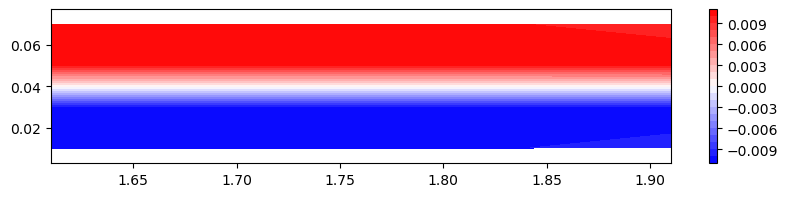

(-0.010106605345137798, 0.010105724482181604)

In [161]:
x = 1.61:0.10:2.00
y = 0.01:0.02:0.08
E = evaluate(WhitneyRectangleElement(), e0, dof, x, y, n, m, lx, ly, el2ed, el2edd)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

figure(figsize=(10, 2))
contourf(xx', yy', E[:, :, 2], cmap=PyPlot.get_cmap("bwr"), levels=20)
axis("equal"); colorbar();
extrema(E[:,:,2])

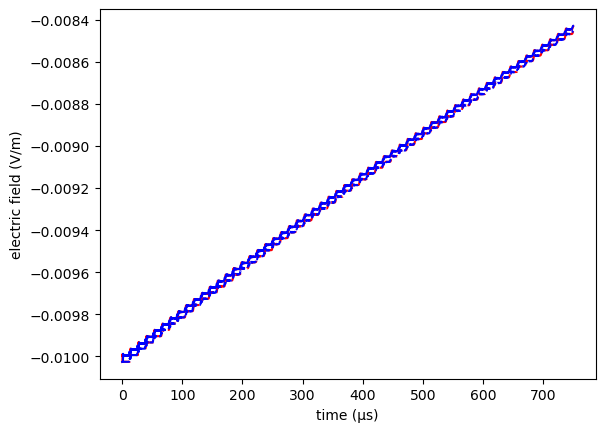

PyObject Text(24.0, 0.5, 'electric field (V/m)')

In [162]:
using PyPlot

ts = 1e9Δt * collect(1:nt)
plot(ts, res[:, 3, 1, 2], "r-")
plot(ts,-res[:, 3, 6, 2], "r--")
plot(ts, res[:, 9, 1, 2], "b-")
plot(ts,-res[:, 9, 6, 2], "b--")
xlabel("time (μs)")
ylabel("electric field (V/m)")

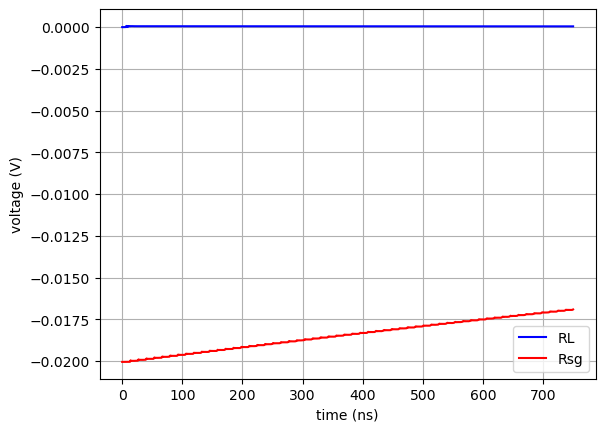

PyObject <matplotlib.legend.Legend object at 0x7f7d20f02790>

In [163]:
ts = 1e9Δt * collect(1:nt)

xlabel("time (ns)")
grid()
plot(ts, vRL, "b-")
plot(ts,-vRsg, "r-")
ylabel("voltage (V)")
legend(["RL", "Rsg"])